# MMSegmentation Tutorial
Welcome to MMSegmentation!

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results.

# Install
We have MMpretrain installed for you when you see this page

# Start trying
Ensure you have selected the right kernel (on the top right corner of jupyter lab interface), the one you have just named <br>
now we change the directory to the installed location

In [1]:
cd mmsegmentation

/home/z890/Downloads/ml_develop_sample/carasml/segmentation/PSPNet/mmsegmentation


/home/z890/.conda/envs/pspv2/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Download a pretrained model

there are plenty of models <br>
you may check what models are available on <br>
https://mmsegmentation.readthedocs.io/en/latest/modelzoo_statistics.html <br>

In [2]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir ./checkpoint
!mkdir ./output

mkdir: cannot create directory ‘./checkpoint’: File exists
mkdir: cannot create directory ‘./output’: File exists


Choose one model from the configs, we use pspnet as an example <br>
download pretrained model

In [3]:
!mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest ./checkpoint

processing pspnet_r50-d8_4xb2-40k_cityscapes-512x1024...
pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth exists in /home/z890/Downloads/ml_develop_sample/carasml/segmentation/PSPNet/mmsegmentation/checkpoint
Successfully dumped pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py to /home/z890/Downloads/ml_develop_sample/carasml/segmentation/PSPNet/mmsegmentation/checkpoint


The above code downloads weights of a pretrained model <br>
if it was not successful <br>
go to terminal, and run: <br>
conda activate "your environment name" <br>
cd mmdetection <br>
mim download mmdet --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest ./checkpoint <br>

# Inference the detector

/home/z890/Downloads/ml_develop_sample/carasml/segmentation/PSPNet/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/z890/Downloads/ml_develop_sample/carasml/segmentation/PSPNet/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: ./checkpoint/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth


/home/z890/Downloads/ml_develop_sample/carasml/segmentation/PSPNet/mmengine/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


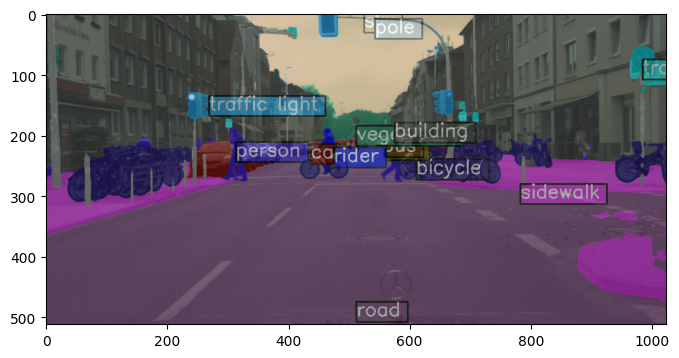

In [4]:
# load the pre-trained model
import mmcv
import mmengine
from mmseg.apis import init_model, inference_model, show_result_pyplot
import matplotlib.pyplot as plt

# Load config file for the model
config_file = './configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py'
# Initialize segmentor with pre-trained weights, we just downloaded
checkpoint_path = './checkpoint/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
model = init_model(config_file, checkpoint_path, 'cuda:0')

# Feed an image to model
img = mmcv.imread('demo/demo.png')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))


## Finetune a semantic segmentation model on a new dataset

To finetune on a customized dataset, the following steps are necessary.
1. Add a new dataset class.
2. Create a config file accordingly.
3. Perform training and evaluation.

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure.
<br>
In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization.
<br>
We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels.
<br>
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object.
<br>
The dataset should have been automatically downloaded and saved at mmsegmentation/, named iccv09Data <br>

# Prepare a demo dataset
We use stanford_background for demonstration here <br>
This tutorial we aim at demonstrating how to start with a dataset with labeled with Labelme, so we have converted the dataset to the annotation format when installing<br>
If you have not label a dataset yet or want a custom dataset, you can use Labelme to label. Unclick Save with Image Data<br>
Use the create polygons function to create segments <br>
You are recommended to label in the order of from far to near <br>
Eg. sky > building > road > foreground object <br>
The dataset should be in below format

Then run the below code to eliminate duplicated and missing annotation for each pixel <br>
It will process your labels under rules: <br>
1. Later segments overwrite earlier ones <br>
2. Unassigned pixels (marked as -1) are replaced by mode of nearby pixels until all pixels are assigned<br>
(you dont need to run this if you use the given stanford_background dataset)

In [5]:
import os
import json
import numpy as np
import cv2
from glob import glob
from scipy import stats
from PIL import Image

# Class info
classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj') # our classes
class_to_idx = {name: idx for idx, name in enumerate(classes)}
palette = [
    [128, 128, 128],  # sky
    [129, 127, 38],   # tree
    [120, 69, 125],   # road
    [53, 125, 34],    # grass
    [0, 11, 123],     # water
    [118, 20, 12],    # bldg
    [122, 81, 25],    # mntn
    [241, 134, 51]    # fg obj
]

import numpy as np
from scipy import stats

def get_neighbors(filled):
    H, W = filled.shape
    padded = np.pad(filled, 1, mode='constant', constant_values=-1)  # pad

    # Extract neighbors by slicing
    neighbors = np.stack([
        padded[0:H,   0:W],    # top-left (-1, -1)
        padded[0:H,   1:W+1],  # top (-1, 0)
        padded[0:H,   2:W+2],  # top-right (-1, +1)
        padded[1:H+1, 0:W],    # left (0, -1)
        padded[1:H+1, 2:W+2],  # right (0, +1)
        padded[2:H+2, 0:W],    # bottom-left (+1, -1)
        padded[2:H+2, 1:W+1],  # bottom (+1, 0)
        padded[2:H+2, 2:W+2],  # bottom-right (+1, +1)
    ], axis=0)  # shape (8, H, W)

    return neighbors

def compute_mode_vectorized(target_neighbors, min_count=2):
    """
    Fully vectorized mode computation across axis=0 for multiple pixels.

    Args:
        target_neighbors (np.ndarray): (8, N_pixels), neighbor labels per pixel
        min_count (int): minimum times a label must appear to be considered mode

    Returns:
        updated_vals: (N_pixels,) array of class indices, or -1 if no valid mode
    """
    # Only keep valid values (>= 0), mark invalid with -1
    masked = np.where(target_neighbors >= 0, target_neighbors, -1)  # (8, N)

    # Get one-hot encoding of each class ID (assuming max 255 classes)
    num_classes = 256
    one_hot = np.zeros((num_classes, masked.shape[0], masked.shape[1]), dtype=np.uint8)

    for cls in range(num_classes):
        one_hot[cls] = (masked == cls)

    # Sum over 8 neighbors → counts for each class per pixel
    counts = np.sum(one_hot, axis=1)  # (num_classes, N)

    # Find the mode (max count per pixel)
    mode_class = np.argmax(counts, axis=0)  # (N,)
    mode_count = counts[mode_class, np.arange(counts.shape[1])]  # (N,)

    # Set to -1 where count < min_count
    mode_class[mode_count < min_count] = -1

    return mode_class.astype(np.int16)
    

def fill_mask_holes(ann_mask: np.ndarray, max_iter=1000):
    """
    Fill unassigned pixels (-1) in ann_mask using neighbor mode logic.

    Args:
        ann_mask (np.ndarray): HxW array of ints with -1 for missing pixels.
        max_iter (int): Maximum number of iterations to avoid infinite loops.
    """
    ann_mask = ann_mask.astype(np.int16)
    filled = ann_mask.copy()
    H, W = filled.shape

    for iteration in range(max_iter):
        mask = (filled < 0)
        if not np.any(mask):
            print(f"✅ All pixels filled in {iteration} iterations.")
            break

        neighbors = get_neighbors(filled)
        valid_mask = neighbors >= 0
        valid_count = np.sum(valid_mask, axis=0)
        process_mask = (filled < 0) & (valid_count >= 3)

        if not np.any(process_mask):
            print("⚠️ No further updates possible, some pixels remain unfilled.")
            break

        mask_flat = process_mask.flatten()  # (H*W,)
        neighbors_flat = neighbors.reshape(8, -1)  # (8, H*W)
        target_neighbors = neighbors_flat[:, mask_flat]  # (8, N_pixels_to_update)

        mode_vals = compute_mode_vectorized(target_neighbors, min_count=2)

        filled_flat = filled.flatten()
        filled_flat[mask_flat] = mode_vals
        filled = filled_flat.reshape(H, W)

    return filled

def convert_annotations_colored(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    json_files = glob(os.path.join(input_dir, '*.json'))

    for json_path in json_files:
        base = os.path.splitext(os.path.basename(json_path))[0]
        img_path = os.path.join(input_dir, base + '.jpg')

        # Load image to get shape
        image = cv2.imread(img_path)
        if image is None:
            print(f"[Skip] Image not found: {img_path}")
            continue

        height, width = image.shape[:2]
        ann_mask = np.full((height, width), -1, dtype=np.int16)

        # Parse JSON
        with open(json_path, 'r') as f:
            data = json.load(f)

        # Process each shape, later ones overwrite earlier ones
        for shape in data.get('shapes', []):
            label = shape['label']
            if label not in class_to_idx:
                continue
            class_id = class_to_idx[label]
            points = np.array(shape['points'], dtype=np.int32)
            mask = np.zeros((height, width), dtype=np.uint8)
            cv2.fillPoly(mask, [points], 1)
            ann_mask[mask == 1] = class_id
        
        # Fill unassigned (-1) pixels using local mode
        negative_count = np.sum(ann_mask < 0)
        if negative_count > 0:
            print(f"Processing {json_path} ({negative_count} negatives)")
            ann_mask = fill_mask_holes(ann_mask)

        # Map to RGB using palette
        color_mask = np.zeros((height, width, 3), dtype=np.uint8)
        for class_id, color in enumerate(palette):
            color_mask[ann_mask == class_id] = color

        # Save color image
        out_path = os.path.join(output_dir, base + '.png')
        Image.fromarray(color_mask).save(out_path)

    print("✅ All annotations converted and saved as colored PNGs.")

# Example usage, we create the folder 'labels'
convert_annotations_colored('dataset/train/images', 'dataset/train/labels')
convert_annotations_colored('dataset/val/images', 'dataset/val/labels')

✅ All annotations converted and saved as colored PNGs.
✅ All annotations converted and saved as colored PNGs.


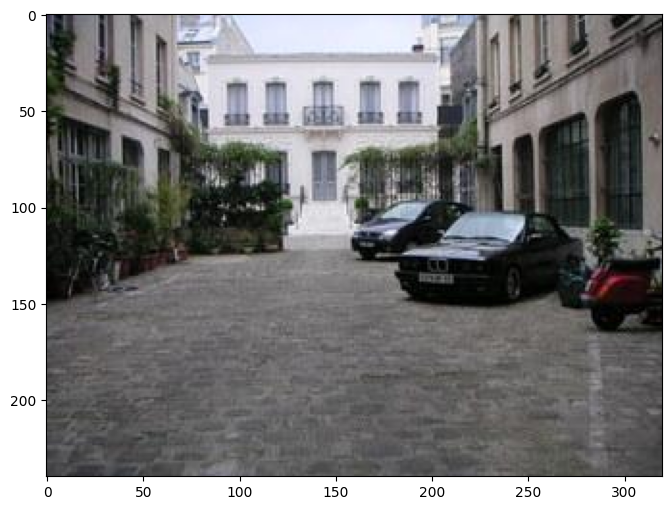

In [6]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt

img = mmcv.imread('iccv09Data/val/images/0000072.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [7]:
# define dataset root and directory for images and annotations
data_root = 'iccv09Data'
img_dir = 'images'
ann_dir = 'labels'
# define class and palette for better visualization
classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34],
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]

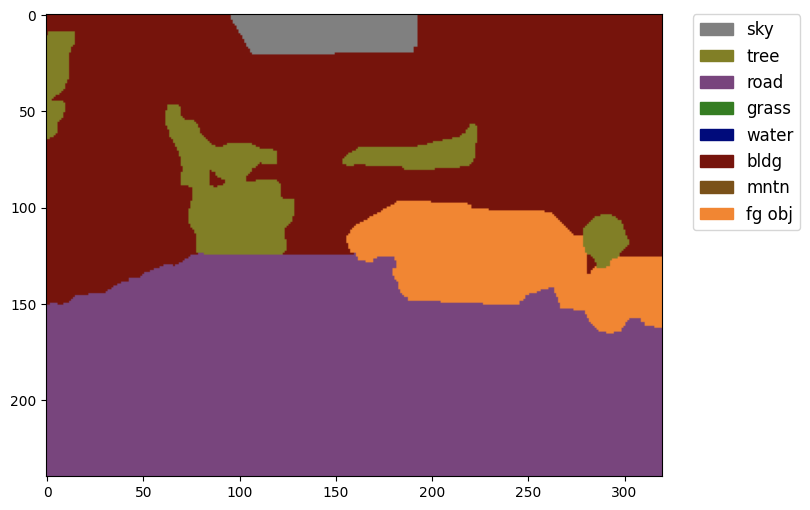

In [8]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
from PIL import Image
import numpy as np
img = Image.open('iccv09Data/val/labels/0000072.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color
patches = [mpatches.Patch(color=np.array(palette[i])/255.,
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
           fontsize='large')

plt.show()

# Train our model

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [9]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

@DATASETS.register_module()
class StanfordBackgroundDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)


### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [10]:
from mmengine import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    512,
    1024,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'data/cityscapes/'
dataset_type = 'CityscapesDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=4000, type='CheckpointHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.

Looks carefully in the configs, identify what need to be revised to fit our model <br>
the layer of 'dict' is chained by a '.' <br>
Here are the list that need to be revised: <br>
 <br>
model.decode_head.num_classes&nbsp;&nbsp;&nbsp;&nbsp;#number of class, we have 8 <br>
model.auxiliary_head.num_classes&nbsp;&nbsp;&nbsp;&nbsp;#number of class, we have 8 <br>
 <br>
optimizer.lr&nbsp;&nbsp;&nbsp;&nbsp;#learning rate, the default is for 8gpu, which maybe to large <br>
optim_wrapper.optimizer.lr&nbsp;&nbsp;&nbsp;&nbsp;#learning rate, the default is for 8gpu, which maybe to large <br>
train_cfg.type&nbsp;&nbsp;&nbsp;&nbsp;#iteration or epoch based training, we use epoch <br>
train_cfg.max_epochs&nbsp;&nbsp;&nbsp;&nbsp;#number of epoch, we needs less epoch for transfer learning <br>
train_cfg.val_interval&nbsp;&nbsp;&nbsp;&nbsp;#Runs validation every N epochs <br>
train_cfg.max_iters&nbsp;&nbsp;&nbsp;&nbsp;#Runs validation every N iteration, but we dont need it as we use epoch based <br>
param_scheduler[0].by_epoch&nbsp;&nbsp;&nbsp;&nbsp;#iteration or epoch based training schedule, we use epoch  <br>
param_scheduler[0].end&nbsp;&nbsp;&nbsp;&nbsp;#number of epoch or iteration <br>
default_hooks.logger.interval&nbsp;&nbsp;&nbsp;&nbsp;#Logs training info every N iterations or epochs <br>
default_hooks.logger.log_metric_by_epoch&nbsp;&nbsp;&nbsp;&nbsp;#Logs training info by epoch or iteration <br>
default_hooks.checkpoint.by_epoch&nbsp;&nbsp;&nbsp;&nbsp;#Saves checkpoint by epoch or iteration <br>
default_hooks.checkpoint.interval&nbsp;&nbsp;&nbsp;&nbsp;#Saves a checkpoint every N iterations or epochs <br>
default_hooks.checkpoint.save_best&nbsp;&nbsp;&nbsp;&nbsp;#Whether saves best checkpoint <br>
 <br>
dataset_type&nbsp;&nbsp;&nbsp;&nbsp;#our dataset type StanfordBackgroundDataset <br>
train_dataloader.dataset.type&nbsp;&nbsp;&nbsp;&nbsp;#our dataset type StanfordBackgroundDataset <br>
train_dataloader.dataset.data_root&nbsp;&nbsp;&nbsp;&nbsp;#the dataset location <br>
train_dataloader.dataset.data_prefix&nbsp;&nbsp;&nbsp;&nbsp;#folder of storing training set images <br>
train_pipeline[2].ratio_range&nbsp;&nbsp;&nbsp;&nbsp;#we make mild augmentation in size <br>
train_pipeline[2].scale&nbsp;&nbsp;&nbsp;&nbsp;#the size after augmentation (width,height)<br>
train_pipeline[3]&nbsp;&nbsp;&nbsp;&nbsp;#we dont need to crop<br>
train_dataloader.dataset.pipeline&nbsp;&nbsp;&nbsp;&nbsp;#consistent with above<br>
train_dataloader.batch_size&nbsp;&nbsp;&nbsp;&nbsp;#set a batch size that fits your gpu <br>
train_dataloader.sampler.type&nbsp;&nbsp;&nbsp;&nbsp;#we need to change it to default to run epoch based training <br>
 <br>
val_dataloader.dataset.type&nbsp;&nbsp;&nbsp;&nbsp;#our dataset type StanfordBackgroundDataset <br>
val_dataloader.dataset.data_root&nbsp;&nbsp;&nbsp;&nbsp;#the dataset location <br>
val_dataloader.dataset.data_prefix&nbsp;&nbsp;&nbsp;&nbsp;#folder of storing validation set images <br>
test_pipeline[1].scale&nbsp;&nbsp;&nbsp;&nbsp;#resize to standard (width,height)<br>
val_dataloader.dataset.pipeline&nbsp;&nbsp;&nbsp;&nbsp;#consistent with above<br>
test_dataloader&nbsp;&nbsp;&nbsp;&nbsp;#same as val_dataloader<br>
 <br>
load_from&nbsp;&nbsp;&nbsp;&nbsp;#set pretrained model, usually preferred to start with pretrained model <br>
  <br>
for configs explanation, you can refer to <br>
https://mmsegmentation.readthedocs.io/en/latest/user_guides/1_config.html <br>
for more augmentation, you can refer to <br>
https://mmsegmentation.readthedocs.io/en/latest/advanced_guides/transforms.html <br>

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [11]:
import cv2

cfg.model.decode_head.num_classes = 8
cfg.model.auxiliary_head.num_classes = 8

cfg.optimizer.lr = cfg.optimizer.lr/2
cfg.optim_wrapper.optimizer.lr = cfg.optim_wrapper.optimizer.lr/2
cfg.train_cfg.type = 'EpochBasedTrainLoop'
cfg.train_cfg.max_epochs = 20
cfg.train_cfg.val_interval = 1
del cfg.train_cfg.max_iters
cfg.param_scheduler[0].by_epoch=True
cfg.param_scheduler[0].end = 10
cfg.default_hooks.logger.interval = 10
cfg.default_hooks.logger.log_metric_by_epoch = True
cfg.default_hooks.checkpoint.by_epoch = True
cfg.default_hooks.checkpoint.interval = 1
cfg.default_hooks.checkpoint.save_best = 'auto' 

cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = 'iccv09Data'
cfg.train_dataloader.dataset.data_prefix = dict(img_path='train/images', seg_map_path='train/labels')
cfg.train_pipeline[2].scale=(320,240)
cfg.train_pipeline[2].ratio_range=(0.9,1.1,)
del cfg.train_pipeline[3]
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.batch_size = 8
cfg.train_dataloader.sampler.type = 'DefaultSampler'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = 'iccv09Data'
cfg.val_dataloader.dataset.data_prefix = dict(img_path='val/images', seg_map_path='val/labels')
cfg.test_pipeline[1].scale = (320,240)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.test_dataloader = cfg.val_dataloader

cfg.load_from = './checkpoint/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

#------------------------------------------------------
config=f'./configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

### Train and Evaluation

In [12]:
%run tools/train.py configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford.py

07/02 13:40:49 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 293111682
    GPU 0: NVIDIA GeForce RTX 5090
    CUDA_HOME: /usr/local/cuda-12.8
    NVCC: Cuda compilation tools, release 12.8, V12.8.61
    GCC: gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0
    PyTorch: 2.7.0+cu128
    PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute_75,cod

/home/z890/Downloads/ml_develop_sample/carasml/segmentation/PSPNet/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/z890/Downloads/ml_develop_sample/carasml/segmentation/PSPNet/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/z890/Downloads/ml_develop_sample/carasml/segmentation/PSPNet/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


07/02 13:40:50 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
07/02 13:40:50 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/z890/Downloads/ml_develop_sample/carasml/segmentation/PSPNet/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


07/02 13:40:50 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
07/02 13:40:51 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
07/02 13:40:51 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c
07/02 13:40:51 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Loads checkpoint by local backend from path: ./checkpoint/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param w

In [13]:
import torch
#after training/testing, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

# plot learning curve

Inference with trained model

In [14]:
#Suppose we use the latest run for example
import os
def get_latest_config(base_dir):
    # Get top-level subdirectories in the base directory
    top_subdirs = [
        os.path.join(base_dir, d)
        for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d))
    ]
    # Sort subdirectories by create time (most recent first)
    top_subdirs.sort(key=os.path.getctime, reverse=True)
    #print(top_subdirs)
    for top_dir in top_subdirs:
        # Walk through the subdirectory tree
        for root, dirs, files in os.walk(top_dir):
            # Look for the specific path vis_data/scalars.json
            if "vis_data" in dirs:
                target = os.path.join(root, "vis_data", "scalars.json")
                if os.path.exists(target):
                    return target
    return None

latest_config = get_latest_config("work_dirs/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford/")
print(latest_config)

work_dirs/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford/20250702_134049/vis_data/scalars.json


['work_dirs/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford/20250702_134049/vis_data/scalars.json']
work_dirs/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford/20250702_134049/vis_data/scalars.json
plot curve of work_dirs/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford/20250702_134049/vis_data/scalars.json, metric is loss


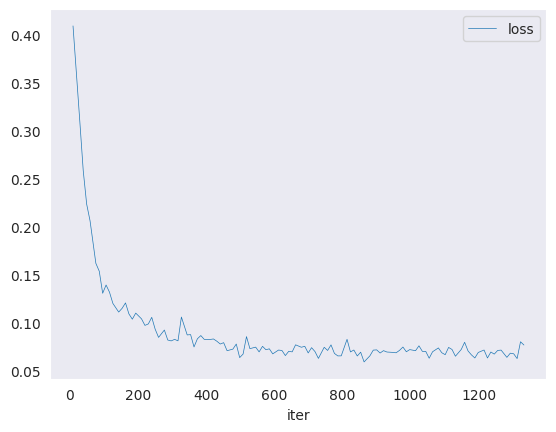

In [15]:
%run tools/analysis_tools/analyze_logs.py {latest_config} --keys loss --legend loss

['work_dirs/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford/20250702_134049/vis_data/scalars.json']
work_dirs/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford/20250702_134049/vis_data/scalars.json
plot curve of work_dirs/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford/20250702_134049/vis_data/scalars.json, metric is mIoU


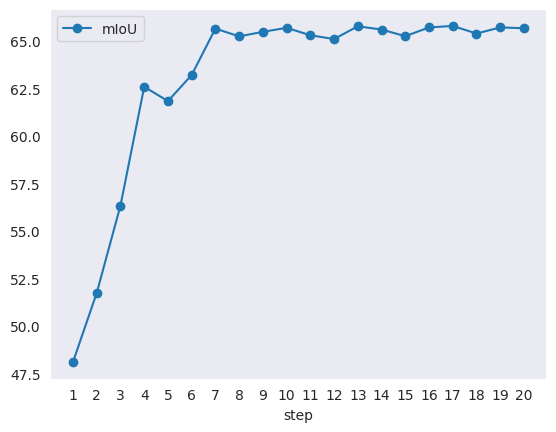

In [16]:
%run tools/analysis_tools/analyze_logs.py {latest_config} --keys mIoU --legend mIoU

# Read the training log
Every epoch, the log prints current training status incluing Loss and learning rate(LR). <br>
and then current accuracy in metrics like mIoU and mAcc. <br>

In ideal scenario, training loss decreases and accuracy increases gradually throughout the training. <br> 
When it comes to the end of training, training loss would still decreases slightly, while accuracy stops improving, and it should be already satisfactory. <br>
 <br>
If training loss decreases and accuracy increases slowly, you may increase learning rate (eg double it) <br>
If both training loss and accuracy flutuate violently, you may decrease learning rate (eg half it) <br>
If accuracy is still improving at the end of training, you may increase number of epoch <br>
If training loss decreases while accuracy stagnates or worsens before getting satisfactory accuracy, you should add more samples or implement stronger augmentation, and ensure the two datasets are alike <br>
If both training loss and accuracy stagnates, and the accuracy is not satisfactory, you should consider choosing a more advanced or larger model <br>

# Augmentations

In our cascade mask rcnn sample, there is a simple augmentation strategy applied. As stated in <br>
train_pipeline:<br>
&nbsp;&nbsp;&nbsp;&nbsp;dict(keep_ratio=True,ratio_range=(0.9,1.1,),scale=(320,240,),type='RandomResize'),<br>
&nbsp;&nbsp;&nbsp;&nbsp;dict(prob=0.5, type='RandomFlip'),<br>

To create more augmentation, we can add it into train_pipeline <br>
for example, copy the below code and paste to the above script of training cfg, right above <br>
#------------------------------------------------------ <br>
config=f'./configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford.py' <br>

### You can visualize the augmented image with below script

In [17]:
%run tools/analysis_tools/browse_dataset.py configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford.py --output-dir ./visualization --not-show

[                                ] 2/536, 29.4 task/s, elapsed: 0s, ETA:    18s

/home/z890/Downloads/ml_develop_sample/carasml/segmentation/PSPNet/mmengine/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 536/536, 8.7 task/s, elapsed: 61s, ETA:     0s

# Inference
Here we inference on a single image <br>

In [18]:
import os
import glob
# Setup a checkpoint file to load, input the location of best pth we trained
def get_best_checkpoint(base_dir):
    best_ckpt = None
    latest_time = 0

    pattern = os.path.join(base_dir, "best_aAcc_epoch_*.pth")
    candidates = glob.glob(pattern)

    for ckpt_path in candidates:
        mtime = os.path.getmtime(ckpt_path)
        if mtime > latest_time:
            latest_time = mtime
            best_ckpt = ckpt_path

    return best_ckpt

best_ckpt = get_best_checkpoint("work_dirs/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford/")
print(f"Using best checkpoint: {best_ckpt}")

Using best checkpoint: work_dirs/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford/best_aAcc_epoch_13.pth


In [19]:
# here we demo how to use another approach to test
from mmseg.apis import MMSegInferencer

# Choose a config that we used for training
config = './work_dirs/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford.py'

# Initialize the DetInferencer
inferencer = MMSegInferencer(
    model=config,
    weights=best_ckpt,
    device='cuda',
    #classes=classes,
    #palette=palette
)

# Use the detector to do inference, 
img = 'iccv09Data/val/images/0000072.jpg'
result = inferencer(img, out_dir='./output')

Loads checkpoint by local backend from path: work_dirs/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford/best_aAcc_epoch_13.pth


/home/z890/Downloads/ml_develop_sample/carasml/segmentation/PSPNet/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/z890/Downloads/ml_develop_sample/carasml/segmentation/PSPNet/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


07/02 13:53:21 - mmengine - WARNING - Failed to search registry with scope "mmseg" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmseg" is a correct scope, or whether the registry is initialized.


Output()

/home/z890/Downloads/ml_develop_sample/carasml/segmentation/PSPNet/mmengine/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


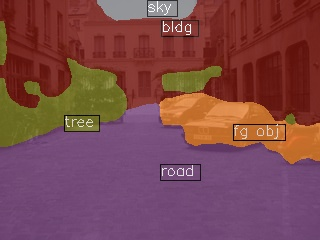

In [20]:
# Show the output image
from PIL import Image
Image.open('./output/vis/0000072.jpg')

# Validation
revise the name of .py and --out location for your own project <br>
it will save the prediction of all samples in validation set in a folder

In [21]:
%run tools/test.py work_dirs/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford.py {best_ckpt} --out output/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford

07/02 13:53:21 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1987562559
    GPU 0: NVIDIA GeForce RTX 5090
    CUDA_HOME: /usr/local/cuda-12.8
    NVCC: Cuda compilation tools, release 12.8, V12.8.61
    GCC: gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0
    PyTorch: 2.7.0+cu128
    PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute_75,co

/home/z890/Downloads/ml_develop_sample/carasml/segmentation/PSPNet/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '


07/02 13:53:21 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
07/02 13:53:21 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/z890/Downloads/ml_develop_sample/carasml/segmentation/PSPNet/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


07/02 13:53:22 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
Loads checkpoint by local backend from path: work_dirs/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford/best_aAcc_epoch_13.pth
07/02 13:53:22 - mmengine - INFO - Load checkpoint from work_dirs/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford/best_aAcc_epoch_13.pth
07/02 13:53:22 - mmengine - INFO - Iter(test) [ 10/134]    eta: 0:00:03  time: 0.0260  data_time: 0.0205  memory: 748  
07/02 13:53:22 - mmengine - INFO - Iter(test) [ 20/134]    eta: 0:00:01  time: 0.0057  data_time: 0.0009  memory: 704  
07/02 13:53:22 - mmengine - INFO - Iter(test) [ 30/134]    eta: 0:00:01  time: 0.0055  data_time: 0.0008  memory: 704  
07/02 13:53:22 - mmengine - INFO - Iter(test) [ 40/134]    eta: 0:00:01  time: 0.0055  data_time: 0.0008  memory: 734  
07/02 13:53:22 - mmengine - INFO - Iter(test) [ 50/134]    eta: 0:00:00  time: 0.0056  data_time: 0.0008  memory: 704  
07/02 13:53:22 - mmengine - INFO - Iter(te

In [22]:
import torch
#after training/testing, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

We can plot the confusion matrix to know how the model makes mistakes <br>
the x axis is prediction and y axis is turth <br>
eg. the first row second column is the area wrongly predicted as tree but is actually sky <br>

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 134/134, 922.8 task/s, elapsed: 0s, ETA:     0s

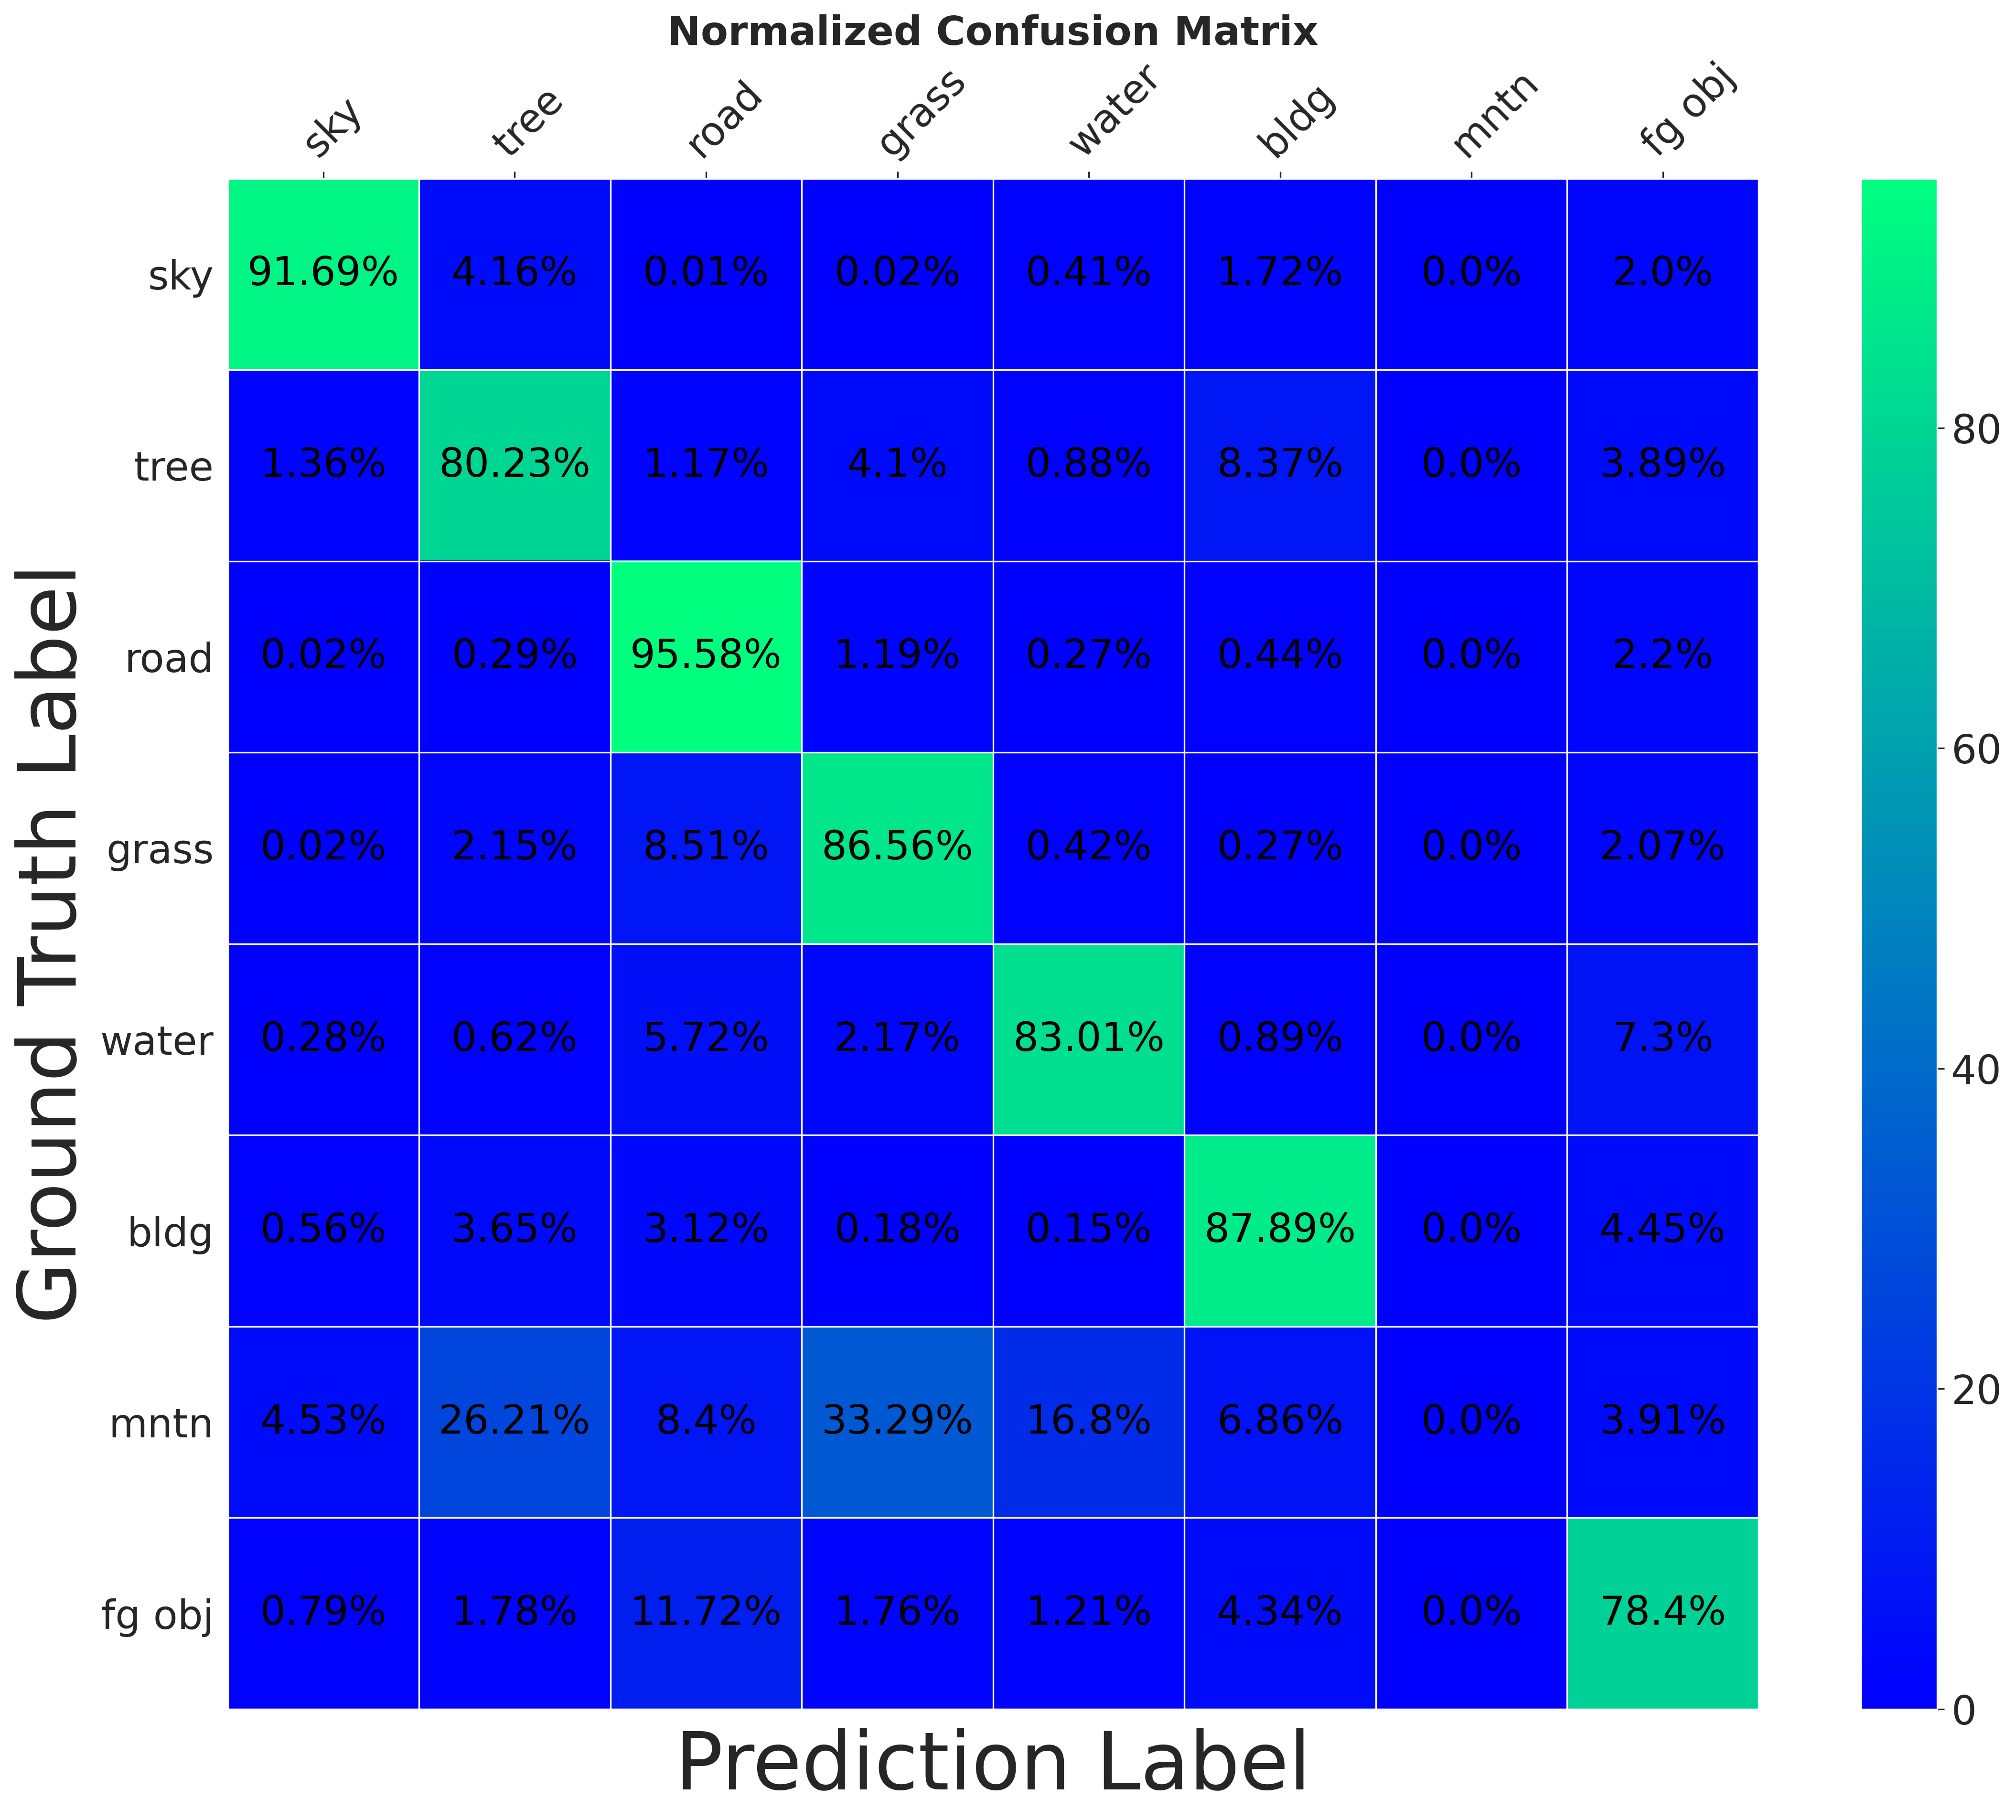

In [23]:
%run tools/analysis_tools/confusion_matrix.py \
work_dirs/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford.py \
output/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_stanford result/confusion_matrix \
--show